$\newcommand{\defeq}{=}$
$\newcommand{\card}[1]{|#1|}$


In [1]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
from IPython.display import display, Math

matplotlib.rcParams['axes.grid'] = True

import pandas as pd

# Matrix Computation

In [44]:
def system(Kbar, K, T):
    A = np.zeros((Kbar + K + T + 2, Kbar + K + T + 2))
    
    A[:Kbar, :Kbar] = np.eye(Kbar)
    A[:Kbar, Kbar] = 1
    
    A[Kbar:Kbar+K, Kbar] = 1
    A[Kbar:Kbar+K, Kbar+1:Kbar+1+K] = -np.eye(K)

    A[Kbar+K: Kbar+K+T, Kbar+K+1:Kbar+K+T+1] = -np.eye(T)
    A[Kbar+K: Kbar+K+T, -1] = 1

    A[-2, Kbar] = -1
    A[-2, -(T+1):] = 1

    A[-1, :Kbar] = 1
    A[-1, -1] = -1

    return A

def system_inv(Kbar, K, T):
    Ainv = np.zeros((Kbar + K + T + 2, Kbar + K + T + 2))

    c = 1 / (Kbar * (T + 1) + 1)
    a = (T + 1) * c
    d = Kbar * c


    Ainv[:Kbar, :Kbar] = np.eye(Kbar) - a
    Ainv[:Kbar, Kbar + K:-1] = c
    Ainv[:Kbar, -1] = a

    Ainv[Kbar, :Kbar] = a
    Ainv[Kbar, Kbar + K:-1] = -c
    Ainv[Kbar, -1] = -a

    Ainv[Kbar+1:Kbar+K+1, :Kbar] = a
    Ainv[Kbar+1:Kbar+K+1, Kbar: Kbar + K] = -np.eye(K)
    Ainv[Kbar+1:Kbar+K+1, Kbar + K:-1] = -c
    Ainv[Kbar+1:Kbar+K+1, -1] = -a

    Ainv[Kbar+K+1:-1, :Kbar] = c
    Ainv[Kbar+K+1:-1, Kbar + K:-2] = d - np.eye(T)
    Ainv[Kbar+K+1:-1, -2] = d
    Ainv[Kbar+K+1:-1, -1] = -c

    Ainv[-1, :Kbar] = c
    Ainv[-1, Kbar + K:-1] = d
    Ainv[-1, -1] = -c

    return Ainv

In [57]:
Kbar, K, T = 13, 4, 10
A = system(Kbar, K, T)
# display(A)
Ainv = np.linalg.inv(A)
Ainv2 = system_inv(Kbar, K, T)
# print(np.array_str((Ainv), precision=2, suppress_small=True))
# print(np.array_str((Ainv2), precision=2, suppress_small=True))
print(np.allclose(Ainv, Ainv2))
print(np.allclose(Ainv @ A, np.eye(A.shape[0])))


True
True


In [42]:
a = Ainv[0, -1]
c = Ainv[-1, 0]
d = Ainv[-1, -2]

X = np.array([a, c, d])

#
u = np.array([
  #  a     c    d
    [Kbar, 1,   0],
    [0, Kbar,  -1],
    [0,    1, T+1]
])

u @ X

array([1., 0., 1.])

In [43]:
print("c")
print(c)
print(1 / (Kbar*(T+1) + 1))

print("d")
print(d)
print(Kbar / (Kbar*(T+1) + 1))

print("a")
print(a)
print((T+1) / (Kbar*(T+1) + 1))

c
0.052631578947368425
0.05263157894736842
d
0.15789473684210528
0.15789473684210525
a
0.3157894736842105
0.3157894736842105


# Projection

In [155]:
class Projection:
    
    def __init__(self, Wini: np.ndarray = None, bini: np.ndarray = None, S: np.ndarray = None, T: np.ndarray= None, epsilon: float = 1e-4):
        self.Wini = Wini
        self.bini = bini
        self.S = S
        self.T = T
        self.epsilon = epsilon

        self.b = None
        self.lambda0: float = None
        self.lambdat: np.ndarray = None
        self.W = None
        self.loss = None
        self.summary = None

    @staticmethod
    def left_cond(Wini: np.ndarray = None, bini: np.ndarray = None, S: np.ndarray = None, epsilon: float = 1e-4):
        lb = Wini[~S].sum()
        return lb  <= bini * (1 + epsilon)  # Small relaxation for numerical errors
        
    @staticmethod
    def right_cond(Wini: np.ndarray = None, bini: np.ndarray = None, S: np.ndarray = None, epsilon: float = 1e-4):
        ub = Wini[S].min()
        return ub >= bini * (1 - epsilon)  # Small relaxation for numerical errors

    @staticmethod
    def left_margin(Wini: np.ndarray = None, bini: np.ndarray = None, S: np.ndarray = None):
        lb = Wini[~S].sum()
        return bini - lb

    @staticmethod
    def right_margin(Wini: np.ndarray = None, bini: np.ndarray = None, S: np.ndarray = None):
        ub = Wini[S].min()
        return ub - bini

    def lagrangian_cond(self,):
        if self.lambdat is not None and (self.lambdat[self.T] < -self.epsilon).any():
            return False
        
        if self.lambda0 is not None and self.lambda0 < -self.epsilon:
            return False

        return True


    def get_summary(self, Wini, bini, S, T=None):
        return {
            "b": self.b,
            "lambda0": self.lambda0,
            "loss": self.loss,
            "lambdat": self.lambdat[T] if self.lambdat is not None else None,
            "W": self.W,
            "left_cond_init": self.left_cond(Wini=Wini, bini=bini, S=S, epsilon=self.epsilon),
            "right_cond_init": self.right_cond(Wini=Wini, bini=bini, S=S),
            "left_cond_proj": self.left_cond(Wini=self.W, bini=self.b, S=S, epsilon=self.epsilon),
            "right_cond_proj": self.right_cond(Wini=self.W, bini=self.b, S=S),
            "left_margin_init": self.left_margin(Wini=Wini, bini=bini, S=S),
            "right_margin_init": self.right_margin(Wini=Wini, bini=bini, S=S),
            "left_margin_proj": self.left_margin(Wini=self.W, bini=self.b, S=S),
            "right_margin_proj": self.right_margin(Wini=self.W, bini=self.b, S=S),
            "lagrangian_cond": self.lagrangian_cond(),
        }

    def projection_left_right(self,):
        Wini, bini, T, S = self.Wini, self.bini, self.T, self.S
        omega = np.ones_like(Wini).astype(bool)

        # card_sbar = np.float32(omega.sum() - S.sum())
        card_sbar = (~S).sum()
        card_T = T.sum()
        wsum_T = Wini[T].sum()

        denom = np.float32(1 / (1 + card_sbar * (card_T - 1)))

        self.b = denom * (Wini[~S].sum() + card_sbar * (wsum_T + bini))
        self.lambda0 = denom * ((card_T - 1) * Wini[~S].sum() - wsum_T - bini)

        self.lambdat = np.zeros_like(Wini)
        self.lambdat[T] = self.b - Wini[T]

        W = np.zeros_like(Wini)
        W[T] = self.b
        W[S & ~T] = Wini[S & ~T]
        W[~S] = Wini[~S] - self.lambda0
        self.W = W

        # self.loss = ((Wini[T] - self.b)**2).sum() + card_sbar * self.lambda0 ** 2 + (self.b - bini) ** 2
        self.loss = 1/2 * (((self.W - Wini) ** 2).sum() + (self.b - bini) ** 2)

        self.summary = self.get_summary(Wini=Wini, bini=bini, S=S, T=T)

        return self

    def projection_left(self,):
        Wini, bini, T, S = self.Wini, self.bini, self.T, self.S
        omega = np.ones_like(Wini).astype(bool)
        card_sbar = omega.sum() - S.sum()
        
        self.b = ( 1 / (1 + card_sbar)) * (Wini[~S].sum() + card_sbar * bini)
        self.lambda0 = self.b - bini

        W = np.zeros_like(Wini)
        W[~S] = Wini[~S] - self.lambda0
        W[S] = Wini[S]
        self.W = W

        self.loss = 1/2 * (((self.W - Wini) ** 2).sum() + (self.b - bini) ** 2)

        self.summary = self.get_summary(Wini=Wini, bini=bini, S=S, T=T)

        return self

    def projection_right(self,):
        Wini, bini, T, S = self.Wini, self.bini, self.T, self.S
        self.b = (1 / (1 + T.sum())) * (Wini[T].sum() + bini)
        
        self.lambdat = np.zeros_like(Wini)
        self.lambdat[T] = self.b - Wini[T]

        W = np.zeros_like(Wini)
        W[T] = self.b
        W[~T] = Wini[~T]
        self.W = W

        self.loss = 1/2 * (((self.W - Wini) ** 2).sum() + (self.b - bini) ** 2)

        self.summary = self.get_summary(Wini=Wini, bini=bini, S=S, T=T)

        return self


In [156]:
class MultiPlot:

    def __init__(self, nrow, ncol, *args, **kwargs):
        self.nrow = nrow
        self.ncol = ncol
        self.fig = plt.figure(*args, **kwargs)
    
    def add_subplot(self, pos, nrow=None, ncol=None, *args, **kwargs):
        if nrow is None:
            nrow = self.nrow
        if ncol is None:
            ncol = self.ncol
        if isinstance(pos, tuple):
            pos = (pos[0] - 1) * self.ncol + pos[1]
        return self.fig.add_subplot(nrow, ncol, pos, *args, **kwargs)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

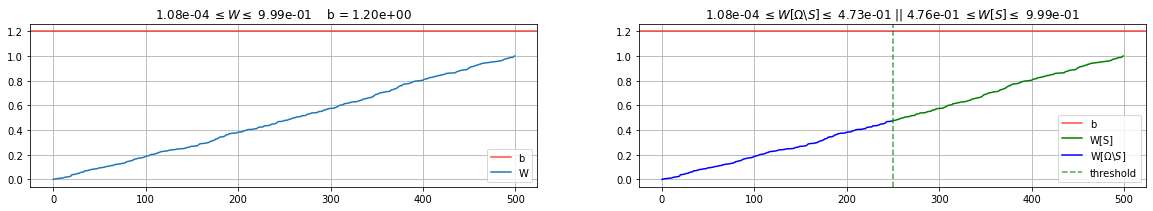

In [187]:
####### Weights initialization #######

# W = np.load("weights.npy")
# b = np.load("bias.npy")
W = np.unique(np.random.rand(500))
b = 1.2
omega = np.ones_like(W).astype(bool)
epsilon = 1e-4  # for numerical stability

idx_S = len(W) // 2
thresh = W[idx_S]
S = W >= thresh
S_idx = np.where(S)[0]
Sbar_idx = np.where(~S)[0]

####### Prints #######

display(Math(r"\sum_{k \in \Omega \backslash S}w_k \leq b: " + f"{Projection.left_cond(Wini=W, bini=b, S=S)}"),)
display(Math(r"b \leq \min_{s \in S}w_s: " + f"{Projection.right_cond(Wini=W, bini=b, S=S)}"),)

fig = plt.figure(figsize=(10*2, 3))
ax = fig.add_subplot(121)
ax.axhline(y=b, c="r", label="b", alpha=.7)
ax.plot(W, label="W");
ax.set_title(fr"{W.min():.2e} $\leq W \leq$ {W.max():.2e}    b = {b:.2e}")
ax.legend();

ax = fig.add_subplot(122)
ax.axhline(y=b, c="r", label="b", alpha=.7)
ax.plot(S_idx, W[S], label="W[S]", c="g");
ax.plot(Sbar_idx, W[~S], label=r"W[$\Omega \backslash S$]", c="b");
ax.set_title(fr"{W[~S].min():.2e} $\leq W[\Omega \backslash S] \leq$ {W[~S].max():.2e} || {W[S].min():.2e} $\leq W[S] \leq$ {W[S].max():.2e}")
ax.axvline(x=idx_S, c="g", label="threshold", alpha=.7, ls="--")
ax.legend();




In [188]:
# Left Right Projection

all_Ts = np.arange(idx_S+1, len(W))
all_res = []
for idx, idx_T in enumerate(all_Ts):
    T = S & (W <= W[idx_T])
    proj = Projection(Wini=W, bini=b, S=S, T=T, epsilon=epsilon).projection_left_right()
    res = proj.summary
    res["idx_T"] = idx_T
    res["T"] = T
    res["proj"] = proj
    all_res.append(res)

df4 = pd.DataFrame(all_res, )
df4.index = df4["idx_T"]
df4["lambdat_neg"] = df4["lambdat"].apply(lambda x: (x < -epsilon).sum())
# df4["Ws_min"] = df4["W"].apply(lambda x: x[S].min())


good_idx = np.where(
    # (df.lambda0.values > 0) & (df["lambdat_neg"] == 0) & (df["Ws_min"] - df["b"] >= 0)
    df4["right_cond_proj"] & df4["left_cond_proj"] & df4["lagrangian_cond"]
)[0]
print("Possibles Ts:", len(good_idx))
if len(good_idx) == 0:
    best_idx = None
    print("No solution found")
else:
    best_idx = df4["loss"].iloc[good_idx].idxmin()
    print("Constraint left", df4.loc[best_idx, "left_cond_proj"], "Margin left", df4.loc[best_idx, "left_margin_proj"])
    print("constraint right", df4.loc[best_idx, "right_cond_proj"], "Margin right", df4.loc[best_idx, "right_margin_proj"])
    print("Wproj min", df4.loc[best_idx, "W"].min(),)
print("Best idx", best_idx)



Possibles Ts: 1
Constraint left True Margin left -1.1010178890824562e-07
constraint right True Margin right 0.0
Wproj min -0.2286664989870151
Best idx 295


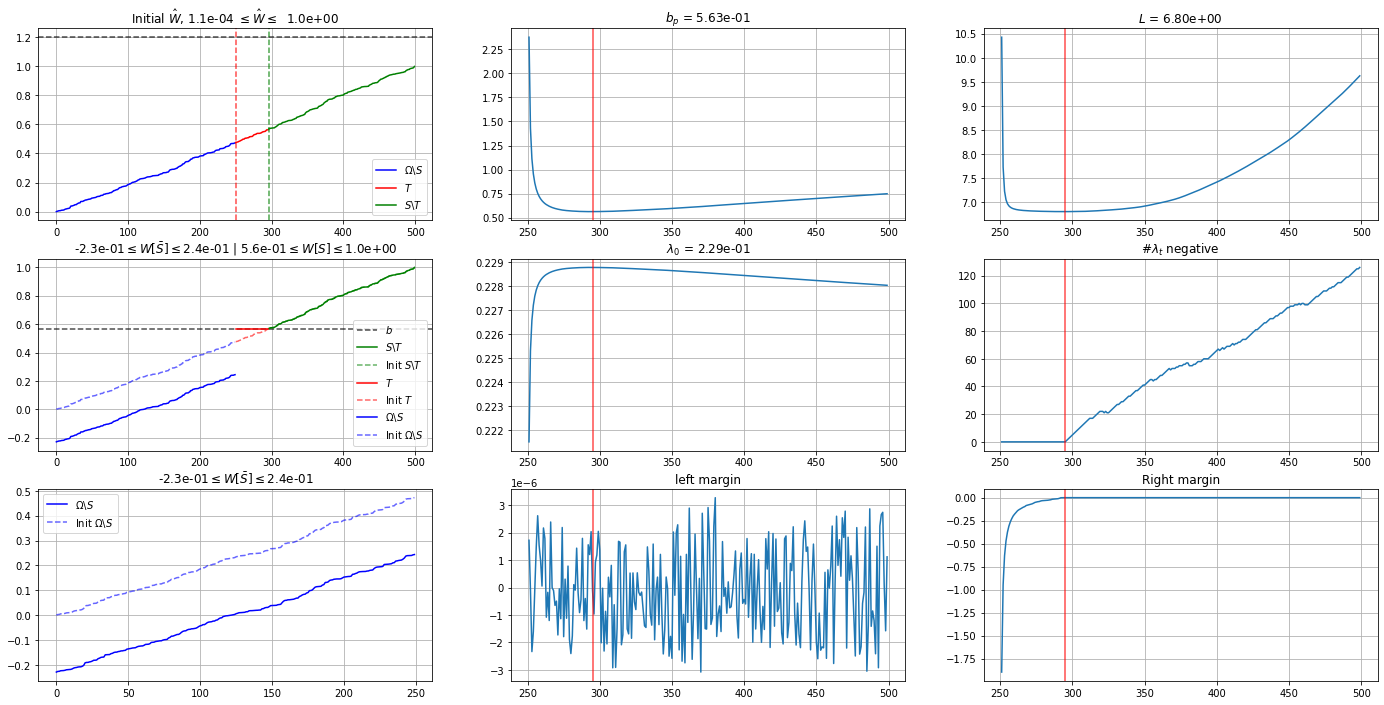

In [189]:
mplot = MultiPlot(3, 3, figsize=(6*4, 6*2))

# Loss wrt T
ax = mplot.add_subplot((1, 3))
ax.plot(all_Ts, df4.loss)
if best_idx is not None:
    ax.axvline(best_idx, color="red", alpha=.7)
    ax.set_title(rf"$L$ = {df4.loc[best_idx, 'loss']:.2e}")
else:
    ax.set_title(rf"$L$")

# Number of negative lagrangians lambda_t wrt T
ax = mplot.add_subplot((2, 3))
ax.plot(all_Ts, df4.lambdat_neg,)
if best_idx is not None:
    ax.axvline(best_idx, color="red", alpha=.7)
ax.set_title(r"#$\lambda_t$ negative")


# Lambda 0 wrt T
ax = mplot.add_subplot((2, 2))
ax.plot(all_Ts, df4.lambda0,)
if best_idx is not None:
    ax.axvline(best_idx, color="red", alpha=.7)
    ax.set_title(rf"$\lambda_0$ = {df4.loc[best_idx, 'lambda0']:.2e}")
else:
    ax.set_title(rf"$\lambda_0$")

# Constraint right margin wrt T
ax = mplot.add_subplot((3, 3))
ax.plot(all_Ts, df4["right_margin_proj"],)
if best_idx is not None:
    ax.axvline(best_idx, color="red", alpha=.7)
ax.set_title("Right margin")

# Constraint left margin wrt T
ax = mplot.add_subplot((3, 2))
ax.plot(all_Ts, df4["left_margin_proj"],)
if best_idx is not None:
    ax.axvline(best_idx, color="red", alpha=.7)
ax.set_title("left margin")

# b wrt T
ax = mplot.add_subplot((1, 2))
ax.plot(all_Ts, df4.b,)
if best_idx is not None:
    ax.axvline(best_idx, color="red", alpha=.7)
    ax.set_title(rf"$b_p$ = {df4.loc[best_idx, 'b']:.2e}")
else:
    ax.set_title(rf"$b_p$")


legend_colors = [Line2D([0], [0], color="blue", lw=4),
                Line2D([0], [0], color="green", lw=4),
                Line2D([0], [0], color="red", lw=4)]
legend_names = [r"$\Omega \backslash S$", r"$S \backslash T$", r"$T$"]


ax = mplot.add_subplot((1, 1))
# ax = mplot.add_subplot((1, 1,), nrow=2)
ax.axhline(y=b, color="black", alpha=.7, ls="--")
ax.plot(Sbar_idx, W[~S], c="b", label=r"$\Omega \backslash S$")
if best_idx is not None:
    best_T = df4.loc[best_idx, "T"]
    T_idx = np.where(best_T)[0]
    ax.plot(T_idx, W[best_T], c="r", label=r"$T$")
    ax.axvline(x=T_idx[0], c="r", alpha=.7, ls="--")
    
    Tbar_idx = np.where(S & ~best_T)[0]
    ax.plot(Tbar_idx, W[~best_T & S], c="g", label=r"$S \backslash T$")
    ax.axvline(x=Tbar_idx[0], c="g", alpha=.7, ls="--")
ax.set_title(rf"Initial $\hat W$, {W.min():.1e} $\leq \hat W \leq $  {W.max():.1e}")
ax.legend()

if best_idx is not None:
    Wbest = df4.loc[best_idx, "W"]
    bbest = df4.loc[best_idx, "b"]

    # ax = mplot.add_subplot((2, 1), nrow=2,)
    ax = mplot.add_subplot((2, 1))
    # ax.hist(Wbest[~S], alpha=.5, density=True, bins=10, label="~S")
    ax.set_title(fr"{Wbest[~S].min():.1e}$\leq W[\bar S] \leq ${Wbest[~S].max():.1e} | {Wbest[S].min():.1e}$\leq W[S] \leq ${Wbest[S].max():.1e}")
    
    ax.axhline(bbest, c="k", alpha=.7, ls="--", label=r"$b$")
    ax.plot(Tbar_idx, Wbest[~best_T & S], c="g", label=r"$S \backslash T$")
    ax.plot(Tbar_idx, W[~best_T & S], c="g", alpha=.6, ls="--", label=r"Init $S \backslash T$")

    ax.plot(T_idx, Wbest[best_T], c="r", label=r"$T$")
    ax.plot(T_idx, W[best_T], c="r", alpha=.6, ls="--", label=r"Init $T$")
    # ax.axvline(x=T_idx[0], c="r", alpha=.7, ls="--")
    ax.plot(Sbar_idx, Wbest[~S], c="b", label=r"$\Omega \backslash S$")
    ax.plot(Sbar_idx, W[~S], c="b", alpha=.6, ls="--", label=r"Init $\Omega \backslash S$")
    ax.legend()

    ax = mplot.add_subplot((3, 1))
    ax.plot(Sbar_idx, Wbest[~S], c="b", label=r"$\Omega \backslash S$")
    ax.plot(Sbar_idx, W[~S], c="b", alpha=.6, ls="--", label=r"Init $\Omega \backslash S$")
    ax.set_title(fr"{Wbest[~S].min():.1e}$\leq W[\bar S] \leq ${Wbest[~S].max():.1e}")
    ax.legend()
    # ax.axvline(x=Tbar_idx[0], c="g", alpha=.7, ls="--")




In [190]:
row = df4.loc[best_idx]
# Wproj = np.where(row["W"] < 0, 0, row["W"])
Wproj = np.where(~S, 0, row["W"])
# Wproj = row["W"]
proj = Projection(Wini=Wproj, bini=row["b"], S=S, T=row["T"])

print(Projection.left_cond(Wini=Wproj, bini=row["b"], S=S), Projection.right_cond(Wini=Wproj, bini=row["b"], S=S))
print(Projection.left_margin(Wini=Wproj, bini=row["b"], S=S), Projection.right_margin(Wini=Wproj, bini=row["b"], S=S))
print(1/2 * (((W - Wproj)**2).sum() + (row["b"] - b) ** 2))
print(1/2 * (((W - row["W"])**2).sum() + (row["b"] - b) ** 2))


True True
0.5630573071863162 0.0
9.293924736321197
6.803465119187398


In [191]:
all_Ts = np.arange(idx_S+1, len(W))
all_res = []
for idx, idx_T in enumerate(all_Ts):
    T = S & (W <= W[idx_T])
    proj = Projection(Wini=W, bini=b, S=S, T=T).projection_right()
    res = proj.summary
    res["idx_T"] = idx_T
    res["T"] = T
    res["proj"] = proj
    all_res.append(res)

df2 = pd.DataFrame(all_res, )
df2.index = df2["idx_T"]
df2["lambdat_neg"] = df2["lambdat"].apply(lambda x: (x < 1e-5).sum())
df2["Ws_min"] = df2["W"].apply(lambda x: x[S].min())

good_idx = np.where(
    df2["right_cond_proj"] & df2["lagrangian_cond"]
)[0]
print("Possibles Ts:", len(good_idx))
if len(good_idx) == 0:
    best_idx = None
    print("No solution found")
else:
    # best_idx = df2.index[good_idx[0][0]]
    best_idx = df2["loss"].iloc[good_idx].idxmin()

    print("Constraint left", df2.loc[best_idx, "left_cond_proj"], "Margin left", df2.loc[best_idx, "left_margin_proj"])
    print("constraint right", df2.loc[best_idx, "right_cond_proj"], "Margin right", df2.loc[best_idx, "right_margin_proj"])
print("Best idx", best_idx)




Possibles Ts: 1
Constraint left False Margin left -57.23062304967187
constraint right True Margin right 0.0
Best idx 274


In [192]:
df2.loc[df2["right_cond_proj"] & df2["left_cond_proj"], ["loss"]]

,loss
idx_T,


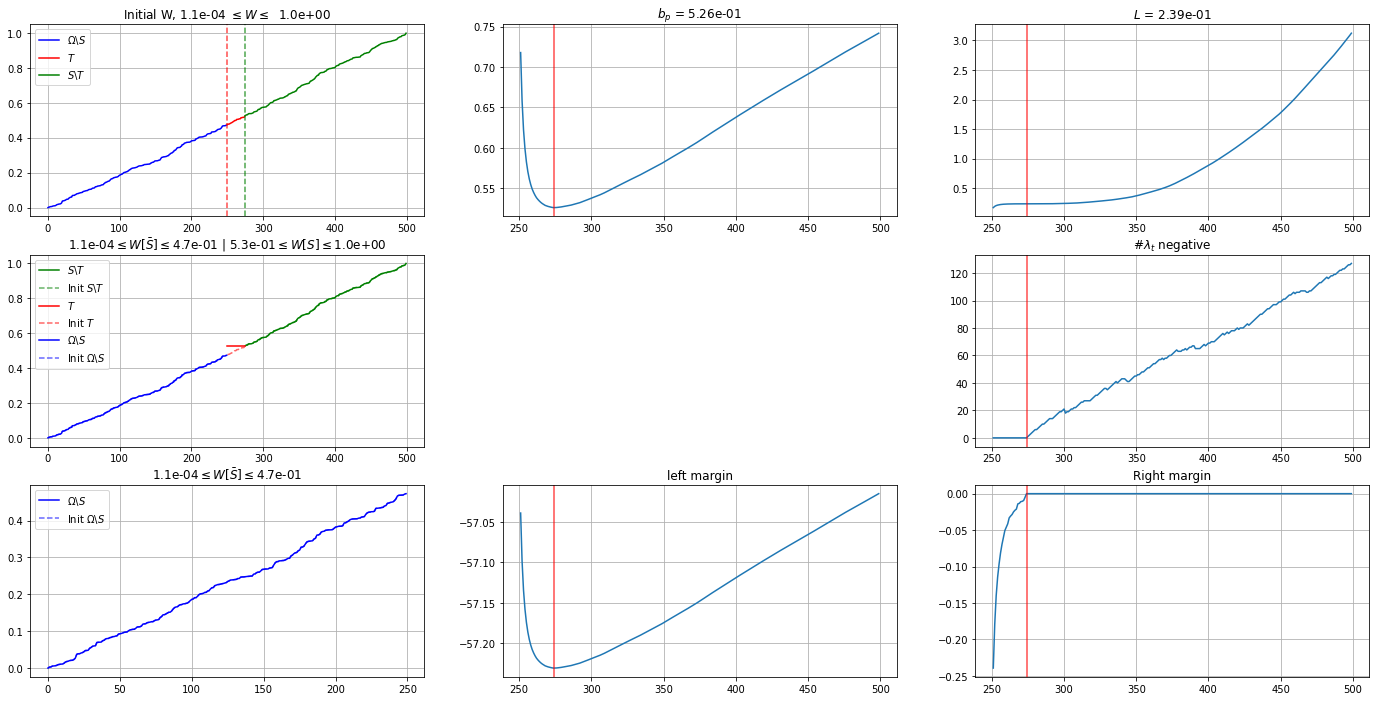

In [193]:


# mplot = plt.figure(figsize=(6*4, 6*2))
mplot = MultiPlot(3, 3, figsize=(6*4, 6*2))

# Loss wrt T
ax = mplot.add_subplot((1, 3))
ax.plot(all_Ts, df2.loss)
if best_idx is not None:
    ax.axvline(best_idx, color="red", alpha=.7)
    ax.set_title(rf"$L$ = {df2.loc[best_idx, 'loss']:.2e}")
else:
    ax.set_title(rf"$L$")

# Number of negative lagrangians lambda_t wrt T
ax = mplot.add_subplot((2, 3))
ax.plot(all_Ts, df2.lambdat_neg,)
if best_idx is not None:
    ax.axvline(best_idx, color="red", alpha=.7)
ax.set_title(r"#$\lambda_t$ negative")


# Constraint right margin wrt T
ax = mplot.add_subplot((3, 3))
ax.plot(all_Ts, df2["right_margin_proj"],)
# ax.plot(all_Ts, df2["Ws_min"] - df2.b,)
if best_idx is not None:
    ax.axvline(best_idx, color="red", alpha=.7)
# ax.set_title(r"$\min_S W - b$")
ax.set_title("Right margin")

# Constraint left margin wrt T
ax = mplot.add_subplot((3, 2))
ax.plot(all_Ts, df2["left_margin_proj"],)
if best_idx is not None:
    ax.axvline(best_idx, color="red", alpha=.7)
ax.set_title("left margin")
# ax.axhline(y=-epsilon, color="red", alpha=.3, ls="--")
# ax.axhline(y=+epsilon, color="red", alpha=.3, ls="--")

# b wrt T
ax = mplot.add_subplot((1, 2))
ax.plot(all_Ts, df2.b,)
if best_idx is not None:
    ax.axvline(best_idx, color="red", alpha=.7)
    ax.set_title(rf"$b_p$ = {df2.loc[best_idx, 'b']:.2e}")
else:
    ax.set_title(rf"$b_p$")


legend_colors = [Line2D([0], [0], color="blue", lw=4),
                Line2D([0], [0], color="green", lw=4),
                Line2D([0], [0], color="red", lw=4)]
legend_names = [r"$\Omega \backslash S$", r"$S \backslash T$", r"$T$"]


ax = mplot.add_subplot((1, 1))
# ax = mplot.add_subplot((1, 1,), nrow=2)
ax.plot(Sbar_idx, W[~S], c="b", label=r"$\Omega \backslash S$")
if best_idx is not None:
    best_T = df2.loc[best_idx, "T"]
    T_idx = np.where(best_T)[0]
    ax.plot(T_idx, W[best_T], c="r", label=r"$T$")
    ax.axvline(x=T_idx[0], c="r", alpha=.7, ls="--")
    
    Tbar_idx = np.where(S & ~best_T)[0]
    ax.plot(Tbar_idx, W[~best_T & S], c="g", label=r"$S \backslash T$")
    ax.axvline(x=Tbar_idx[0], c="g", alpha=.7, ls="--")
ax.set_title(rf"Initial W, {W.min():.1e} $\leq W \leq $  {W.max():.1e}")
ax.legend()

if best_idx is not None:
    Wbest = df2.loc[best_idx, "W"]

    # ax = mplot.add_subplot((2, 1), nrow=2,)
    ax = mplot.add_subplot((2, 1))
    # ax.hist(Wbest[~S], alpha=.5, density=True, bins=10, label="~S")
    ax.set_title(fr"{Wbest[~S].min():.1e}$\leq W[\bar S] \leq ${Wbest[~S].max():.1e} | {Wbest[S].min():.1e}$\leq W[S] \leq ${Wbest[S].max():.1e}")
    
    ax.plot(Tbar_idx, Wbest[~best_T & S], c="g", label=r"$S \backslash T$")
    ax.plot(Tbar_idx, W[~best_T & S], c="g", alpha=.6, ls="--", label=r"Init $S \backslash T$")

    ax.plot(T_idx, Wbest[best_T], c="r", label=r"$T$")
    ax.plot(T_idx, W[best_T], c="r", alpha=.6, ls="--", label=r"Init $T$")
    # ax.axvline(x=T_idx[0], c="r", alpha=.7, ls="--")
    ax.plot(Sbar_idx, Wbest[~S], c="b", label=r"$\Omega \backslash S$")
    ax.plot(Sbar_idx, W[~S], c="b", alpha=.6, ls="--", label=r"Init $\Omega \backslash S$")
    ax.legend()

    ax = mplot.add_subplot((3, 1))
    ax.plot(Sbar_idx, Wbest[~S], c="b", label=r"$\Omega \backslash S$")
    ax.plot(Sbar_idx, W[~S], c="b", alpha=.6, ls="--", label=r"Init $\Omega \backslash S$")
    ax.set_title(fr"{Wbest[~S].min():.1e}$\leq W[\bar S] \leq ${Wbest[~S].max():.1e}")
    ax.legend()
    # ax.axvline(x=Tbar_idx[0], c="g", alpha=.7, ls="--")




In [194]:
proj = Projection(Wini=W, bini=b, S=S).projection_left()

for k in ["left_cond_proj", "right_cond_proj", "left_margin_proj", "right_margin_proj"]:
    print(f"{k}: {proj.summary[k]}")
# {k: v for k, v in proj.summary.items() if k not in ["W"]}

left_cond_proj: True
right_cond_proj: False
left_margin_proj: -4.3298697960381105e-14
right_margin_proj: -0.9488382540925584


# Conclusion

In conclusion, for these weights, only the left right projection give results where constraints are respected (actually only one possibility). However, none of these results have all positive weights, which should be respected according to our theory described above.

Where is the mistake?